In [1]:
%pylab inline --no-import-all

import numpy as np
from imageio import imread
import torch as th

plt.rcParams["figure.figsize"] = (8, 8)

Populating the interactive namespace from numpy and matplotlib


The goal of these exercises is to become familiar with standard PyTorch tensor operations. You use PyTorch
to perform some basic image processing tasks, including channel handling, color to gray mapping, and cropping. These image transformations are very common as a preprocessing step when training neural networks.

Throughout these exercises you may find it useful the [torch.Tensor reference manual](https://pytorch.org/docs/stable/tensors.html) and the `tutorial.ipynb` notebook distributed with the
materials of the first week.

The first step when dealing with images is, of course, loading the image from disk. This is typically done using the `imread` function from the `imageio` package:

Text(0.5, 1.0, 'Optomap image of a patient with retinal detachment')

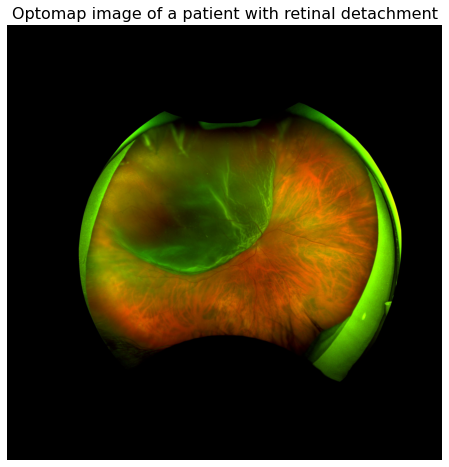

In [2]:
# Load the image with imread
npimage = imread("optomap.jpg")

# Show the image
plt.imshow(npimage)
plt.axis("off")
plt.title("Optomap image of a patient with retinal detachment", fontsize=16)

Note that the output of `imread` is a NumPy array:

In [3]:
# The output of imread is a NumPy array
print(f"Is npimage a NumPy array? {isinstance(npimage, np.ndarray)}")

Is npimage a NumPy array? True


The goal first exercise is simply to convert the NumPy array image into a PyTorch tensor.


### <font color='orange'>Question 1</font>

Write a single line of code to convert `npimage` into a PyTorch tensor. Save the result into the variable `image`.

Print a boolean value indicating whether the resulting `image` is an instance of `torch.Tensor`.

In [4]:
### Solution 1
image = th.tensor(npimage)
print(isinstance(image,th.Tensor))

True


___

`image` should be now a `torch.Tensor`. In the next problem we explore its contents.


### <font color='orange'>Question 2</font>

Print the data type, the shape, the maximum value and the minimum value of `image`.

In [5]:
### Solution 2

# Print the data type
print(image.dtype)
# Print the shape
print(image.shape)
# Print the maximum value
print(image.max())
# Print the mininum value
print(image.min())

torch.uint8
torch.Size([4000, 4000, 3])
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)


___

Images loaded with `imread` typically have a data type `uint8` (8-bit unsigned int) or `float32` (32-bit floating
point). Pixel values range from 0 to 255 for `uint8` images and from 0.0 to 1.0 for `float32` images. When dealing with images, however, neural networks typically do not work well with integer data types, and they are converted from the range [0, 255] `uint8` to [0.0, 1.0] `float32`.

Also, as you saw in the previous exercise, the shape of `image` is `(height, width, channels)`. This is the typical
shape when working with image data with NumPy, and the format understood by NumPy-based plotting tools from Matplotlib (e.g., `plt.imshow`). However, as we will see in future classes, PyTorch customary shape for image data is `(channels, height, width)` (note that it is NOT ~~`(channels, width, height)`~~!).

While these conversions of data type, pixel range, and shape are done automatically in real-world applications (using,
for example, functions from the library `torchvision`), in the next exercise you will be asked to do so using basic
tensor operations.


### <font color='orange'>Question 3</font>

Write a function `convert` which takes an image tensor `image` with data type `uint8`, pixel range `[0, 255]`, and shape
`(H, W, C)` and returns a new tensor with data type `float32`, pixel range `[0.0, 1.0]`, and shape `(C, H, W)`.

Call `convert` to convert `image` into the new format and store the resulting tensor in `image2`. Then, print again the
data type, shape, minimum and maximum values for `image2`.

Hint: one of the conversions can be done with `torch.permute`.

In [6]:
### Solution 3

def convert(image: th.Tensor) -> th.Tensor:
    # TODO.
    image = image.type(th.float32)
    image = image / 255.0
    image = image.permute(2,0,1) # HWC to CHW
    return image

image2 = convert(image)

# Print the data type
print(image2.dtype)
# Print the shape
print(image2.shape)
# Print the maximum value
print(image2.max())
# Print the mininum value
print(image2.min())

torch.float32
torch.Size([3, 4000, 4000])
tensor(1.)
tensor(0.)


___

### <font color='orange'>Question 4</font>

Write a function `reduce8` that takes an image with shape (C, H, W) and reduces each spatial dimension by a factor of 8 (by taking every 8th value). For example, if the input shape is `(3, 4000, 4000)`, the output should be `(3, 500, 500)`.

Solve this using stride indexing.

Note that this is NOT a proper way of down-sampling an image in practice (we should at least blurry the image with a filter to prevent aliasing issues). However, we will ignore these details for now.


In [7]:
### Solution 4

def reduce8(image: th.Tensor) -> th.Tensor:
    # TODO
    image = image[:,::8,::8]
    return image

image3 = reduce8(image2)
print(image3.shape)

assert image2.shape == (3, 4000, 4000)
assert image3.shape == (3, 500, 500)

torch.Size([3, 500, 500])


___
We can check the contents of the resized image.

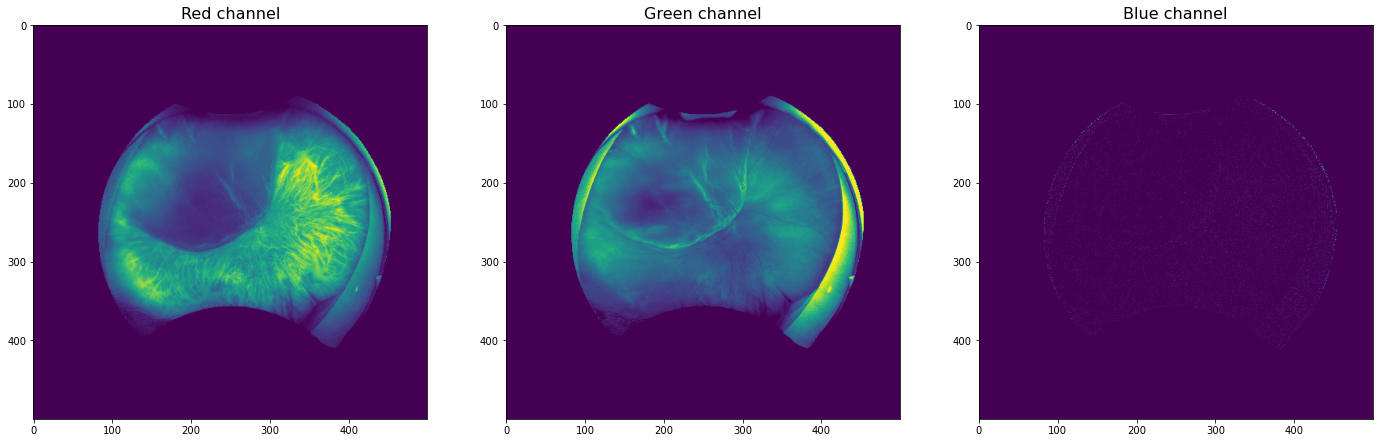

In [8]:
for i, ax in enumerate(plt.subplots(1, 3, figsize=(24, 8))[1].ravel()):
    ax.imshow(image3[i])
    ax.set_title(f"{['Red', 'Green', 'Blue'][i]} channel", fontsize=16)
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

### <font color='orange'>Question 5</font>

Write a function `channel_weighted_sum` that takes a tensor `x` with shape `(C, H, W)` and a vector of weights `w` with
shape `(C,)`, and returns a tensor with shape `(H, W)` obtained by multiplying each channel `x[i]` with the
corresponding weight `w[i]` and summing all channels. Do this using tensor operations, without a for loop.

Hint: use broadcasting and `torch.sum`.

Write a second function `color_to_gray` that takes a tensor with shape `(3, H, W)` representing a RGB-color image and
calls `channel_weighted_sum` to return a tensor `(H, W)` with a gray-scale version of the image. You can use the vector
of weights `[0.3, 0.6, 0.1]` for the red, green, and blue channels respectively. 


In [9]:
# sol5 test dim. 
# so the elements of the i-th dimension make a sum, and the i-th dimension collapses after making the sum

# a = th.arange(12).reshape(3,2,2)
# print(a)
# print(th.sum(a,0).shape)
# th.sum(a, dim=0)

In [10]:
### Solution 5

RGB2GRAY_WEIGHTS = th.tensor([0.3, 0.6, 0.1]) # torch.Size([3])


def channel_weighted_sum(x: th.Tensor, w: th.Tensor) -> th.Tensor:
    # image3 torch.Size([3, 500, 500])
    # make w [3, 1, 1] then broadcast
    temp = x * w[:, None, None] # Index with None to create a new dimension in the given location (3, 1, 1)
    return th.sum(temp, dim=0)

def color_to_gray(image: th.Tensor) -> th.Tensor:
    return channel_weighted_sum(image, RGB2GRAY_WEIGHTS)


image_gray = color_to_gray(image3)

In [11]:
# Print the data type
print(image_gray.dtype)
# Print the shape
print(image_gray.shape)
# Print the maximum value
print(image_gray.max())
# Print the mininum value
print(image_gray.min())

torch.float32
torch.Size([500, 500])
tensor(0.9122)
tensor(0.)


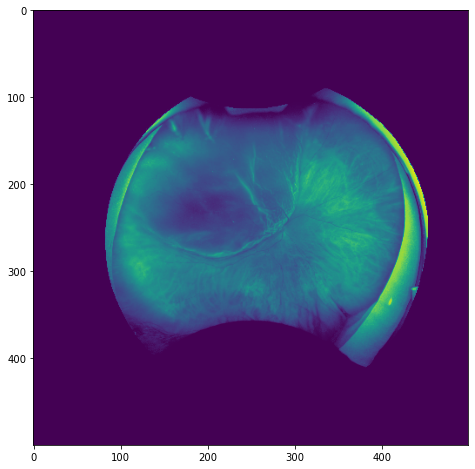

In [12]:
plt.imshow(image_gray)

___

The optomap image has large black margins around the region of interest. The pixel values in these black areas are 0.0
in all channels and, of course, in the gray-scale version of the image. We can easily check that:


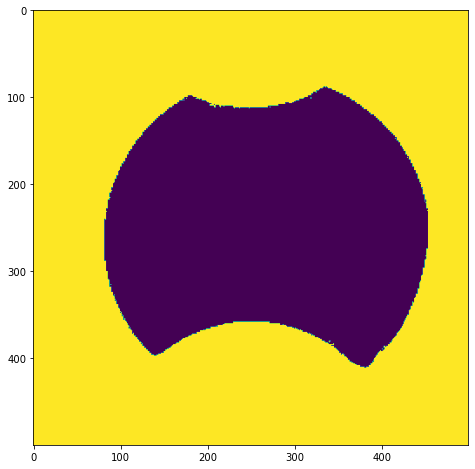

In [13]:
plt.imshow((image3 == 0.0).all(dim=0))

The goal of the next question is to remove black margins to get a tighter version of the region of interest.

### <font color='orange'>Question 6</font>

Write a function `tight_image` that receives a color image in a tensor of shape `(C, H, W)` and returns another tensor of shape `(C, h, w)`, with h<=H and w<=H, where the columns and rows of the input image that only contain zero values have been removed. This function should work for any number of channels `C`, not only for RGB images with 3 channels. 

Note that, for simplicity, the function should remove zero columns and rows not only from the margin of the image but also, should they exist, from the middle of the object of interest. That is, do not try to check whether the row or column to remove belongs to the margin or not. While this is not a good idea in practice, doing otherwise would make the implementation unnecessarily harder.

Hint: use `torch.all` or `torch.any` to find relevant rows and columns, and boolean indexing to select non-zero rows and columns.

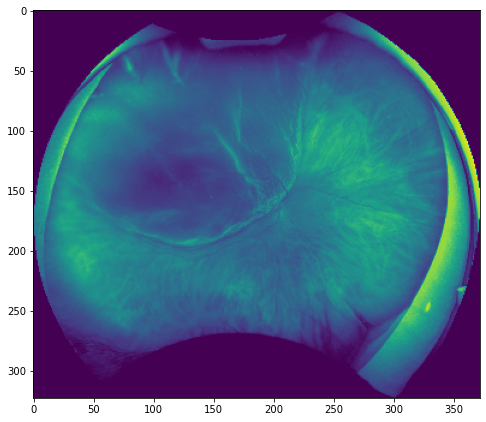

In [14]:
### Solution 6

def tight_image(image: th.Tensor) -> th.Tensor:
    image_c = th.any(image != 0, dim = 0) # if any of one channel is not 0, then should be TRUE, image_c dim [500,500]
    image_h_mask = ~th.all(~image_c, dim = 0) # if the whole column in three channels are 0 then the mask is FALSE
    image_w_mask = ~th.all(~image_c, dim = 1) # if the whole row in three channels are 0 then the mask is FALSE
    image = image[:, image_w_mask, :][:, :, image_h_mask]
    return image 
    

plt.imshow(tight_image(image_gray[None])[0])

___

A properly implemented `tight_image` should at least pass the following assertions. Run the cell and check that you do not receive any errors.

In [15]:

# tight_image of a black image should return an empty image
assert tight_image(th.zeros((3, 5 ,5))).shape == (3, 0, 0)

# tight_image of a random image with no black rows and columns should return the same image
aux = th.rand((3, 5, 5)) + 1  # Add 1 to prevent the (extremely highly) improbable case of getting a row or column of zeros
assert th.all(tight_image(aux) == aux)

# tight_image of a black image with a white rectangle should return the white square
aux = th.zeros((1, 15, 15))
aux[:, 2:6, 7:14] = 1
assert tight_image(aux).shape == (1, 4, 7)

In [16]:
# sol6 test sample
# a = th.randn(12).reshape(3,2,2)
# print(a)
# print(a.shape)
# a_c = th.any(a > 0, dim = 0)
# print(a_c)
# print(a_c.shape)
# a_h_mask = ~th.all(~a_c, dim = 0)
# a_w_mask = ~th.all(~a_c, dim = 1)
# print(a_h_mask)
# print(a_w_mask)
# print(a_w_mask.shape)
# print(a[:,a_w_mask,:])
# a_de_r = a[:,a_w_mask,:]
# print(a_de_r.shape)
# print(a_h_mask.shape)
# print(a_de_r[:,:,a_h_mask])

___